In [ ]:
!pip install mockseries

In [ ]:
from datetime import timedelta
from mockseries.trend import LinearTrend
from mockseries.seasonality import SinusoidalSeasonality
from mockseries.noise import RedNoise

In [ ]:
trend = LinearTrend(coefficient=2, time_unit=timedelta(days=4), flat_base=100)

In [ ]:
seasonality = \
SinusoidalSeasonality(amplitude=20, period=timedelta(days=7)) \
+ SinusoidalSeasonality(amplitude=4, period=timedelta(days=1))

In [ ]:
noise = RedNoise(mean=0, std=3, correlation=0.5)

In [ ]:
timeseries = trend + seasonality + noise

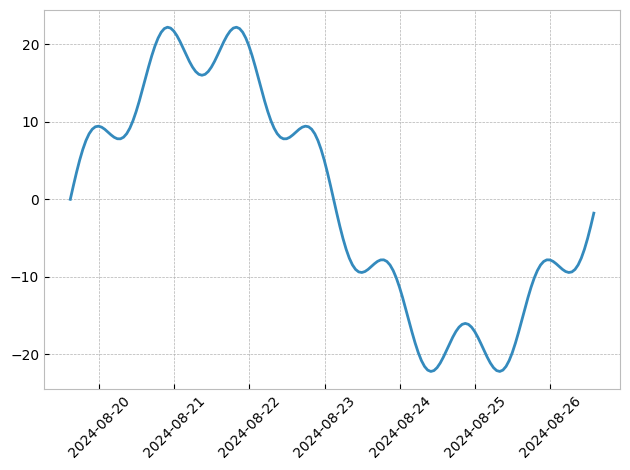

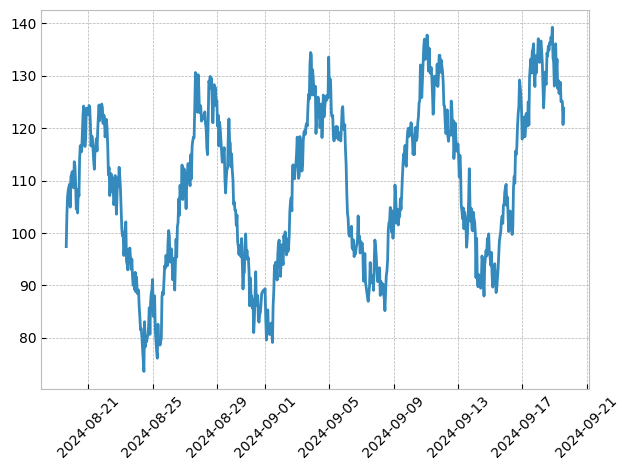

In [ ]:
# preview on minute, hour, day, month, year
seasonality.preview_week()
timeseries.preview_month()

In [ ]:
from datetime import datetime
from mockseries.utils import datetime_range

In [ ]:
time_points = datetime_range(
    granularity=timedelta(hours=1),
    start_time=datetime(2021, 5, 31),
    end_time=datetime(2021, 8, 30),
)
ts_values = timeseries.generate(time_points=time_points)

In [ ]:
from mockseries.utils import plot_timeseries, write_csv

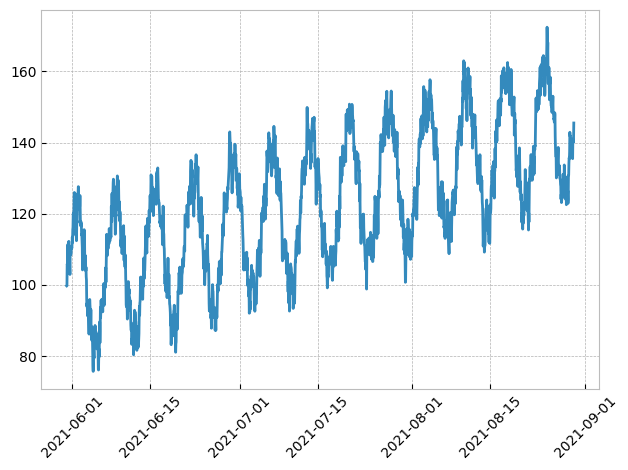

In [ ]:
plot_timeseries(time_points, ts_values)

In [ ]:
!pip install cdsapi

  Preparing metadata (setup.py) ... done
  Created wheel for multiurl: filename=multiurl-0.3.1-py3-none-any.whl size=21131 sha256=01599d7aa2fb6245abe42ca44f6d4d8a733bd2224140b08545b1e9c031fa438a
  Stored in directory: /root/.cache/pip/wheels/9b/d9/5f/36a39fd10d15b5b2d362ad6dc8a1bd28a3b1e14e08357944bf
Successfully built multiurl


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        rank = len(z_mean.shape)

        if rank == 2:  # 2D case
            dim = tf.shape(z_mean)[1]
            epsilon_shape = (batch, dim)
        elif rank == 1:  # 1D case
            epsilon_shape = (batch,)
        elif rank == 3:  # 3D case
            dim1 = tf.shape(z_mean)[1]
            dim2 = tf.shape(z_mean)[2]
            epsilon_shape = (batch, dim1, dim2)
        else:
            raise ValueError("z_mean and z_log_var must be 1D, 2D, or 3D tensors")

        epsilon = tf.keras.backend.random_normal(shape=epsilon_shape)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
import cdsapi
c = cdsapi.Client(url="https://cds.climate.copernicus.eu/api/v2",
                  key="331174:48662cb4-4ed1-4e15-9a00-4eff63b2e125")
for year in range(2018, 2024):
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': '2m_temperature',
            'year': str(year),
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                33.51, -112.01, 33.49,
                -111.99,
            ],
        },
        f't2m_{year}.nc')

2024-08-19 16:19:58,154 INFO Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
INFO:cdsapi:Welcome to the CDS.
 As per our announcements on the Forum, this instance of CDS will soon be decommissioned.
 Please update your cdsapi package to a version >=0.7.0, create an account on CDS-Beta and update your .cdsapirc file. We strongly recommend users to check our Guidelines at https://confluence.ecmwf.int/x/uINmFw
 The current legacy system will be kept for a while, but we will reduce resources gradually until full decommissioning in September 2024.
2024-08-19 16:19:58,158 WARNING MOVE TO

In [ ]:
# import libraries

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df_list = []
for year in range(2018, 2024):
    ds = xr.open_dataset(f't2m_{year}.nc')
    df = pd.DataFrame(index=ds['time'], data=ds['t2m'][:, 0, 0])
    df.index = pd.to_datetime(df.index)
    df_list.append(df)

df = pd.concat(df_list)
df.columns = ['Observed']

# convert Kelvin to Fahrenheit
df.Observed = (df.Observed - 273.15) * 9/5 + 32

df_mst = df.copy()
df_mst.index = df_mst.index.shift(-7, freq='h')
df_mst = df_mst.iloc[7:]

df_yearly = df_mst.resample('YS').mean()
slope = np.polyfit(df_yearly.index.year, df_yearly['Observed'], 1)[0]

df_mst['Climate Adjusted'] = df_mst['Observed'] - 0.07 * (df_mst.index.year - 2024)
df_mst.describe()

,Observed,Climate Adjusted
count,52577.000000,52577.000000
mean,74.616808,74.861847
std,18.430403,18.430171
min,29.407051,29.757051
25%,59.456075,59.714018
50%,74.821154,75.057103
75%,89.679209,89.913235
max,117.288447,117.708447


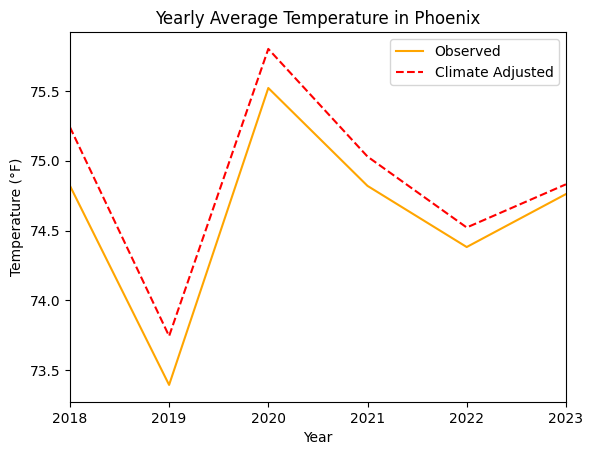

In [ ]:
df_yearly = df_mst.resample('YS').mean()
df_yearly.plot()
plt.title('Yearly Average Temperature in Phoenix')
plt.ylabel('Temperature (°F)')
plt.xlabel('Year')
plt.gca().get_lines()[1].set_linestyle('--')

# set the color of both lines to orange
plt.gca().get_lines()[0].set_color('orange')
plt.gca().get_lines()[1].set_color('red')

plt.legend()
plt.show()

In [ ]:
df_mst.to_csv('observed_time_series.csv')

In [ ]:
offset = round(df_mst['Climate Adjusted'].mean(), 2)
print('offset: ', offset)
scale = round(df_mst['Climate Adjusted'].std(), 2)
print('scale:  ', scale)
dft = (df_mst['Climate Adjusted'] - offset) / scale
k = 64*24
n = dft.shape[0] // k

data = dft.iloc[:n*k].values.reshape(n, k)
index = dft.index[:-k:k]

dft_reshaped = pd.DataFrame(data=data, index=index)

np.random.seed(42)
# shuffle rows
dft_reshaped = dft_reshaped.sample(frac=1)
dft_reshaped.to_csv('phoenix_64days.csv')

dft_reshaped

offset:  74.86
scale:   18.43


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
2020-08-18,1.211300,1.177779,1.078399,0.818103,0.809113,0.799705,0.834341,0.906332,1.178755,1.428319,...,1.021044,1.109830,1.144536,1.101676,0.898596,0.694123,0.491530,0.411037,0.349012,0.135896
2021-05-01,0.336237,0.269823,0.089355,-0.111636,-0.198236,-0.251327,-0.228920,-0.103023,0.177974,0.448138,...,1.380354,1.561159,1.607184,1.616268,1.372078,0.957176,0.682841,0.594827,0.511793,0.537026
2022-09-25,0.836373,0.538532,0.459706,0.239140,0.149121,0.108393,0.036849,0.039816,0.267596,0.648309,...,-0.459237,-0.395178,-0.400573,-0.455798,-0.608191,-0.775015,-1.117494,-1.238195,-1.268066,-1.353568
2022-07-23,1.269546,1.301711,1.337179,0.958017,0.891059,0.846824,0.804006,0.757883,0.795510,0.946487,...,1.351407,1.439134,1.451743,1.475479,1.434684,1.253767,1.010883,0.928280,0.827202,0.777236
2019-05-28,-0.432685,-0.391734,-0.484574,-0.714220,-0.830901,-0.877532,-0.813581,-0.701528,-0.317617,-0.155988,...,1.611057,1.618630,1.308346,1.292148,1.146367,1.069374,0.895334,0.746888,0.668633,0.545220
2022-03-17,-0.358361,-0.421072,-0.524847,-0.753909,-0.800031,-0.821542,-0.815608,-0.894906,-0.638603,-0.463688,...,1.197733,1.253093,1.291191,1.297328,1.228211,1.103465,0.833945,0.707243,0.633070,0.510413
2021-09-06,0.535748,0.485752,0.366719,0.236717,0.221846,0.215252,0.270227,0.312753,0.553512,0.686878,...,0.552839,0.585407,0.592741,0.529153,0.311609,0.080137,-0.225488,-0.358316,-0.403063,-0.528220
2020-02-08,-1.471181,-1.559480,-1.739701,-1.840266,-1.867445,-1.880199,-1.913372,-1.901594,-1.896924,-1.410550,...,-0.461566,-0.405813,-0.368389,-0.411179,-0.445328,-0.408322,-0.574535,-0.643111,-0.699840,-0.751829
2023-08-11,1.057213,0.960360,0.869887,0.634134,0.628098,0.631527,0.636877,0.628989,0.802872,0.883742,...,0.699434,0.707253,0.706430,0.694152,0.630567,0.504013,0.222852,0.101169,0.038955,-0.069833
2019-07-31,0.508898,0.511983,0.540312,0.192092,0.206467,0.228344,0.270136,0.286404,0.344044,0.393269,...,0.606787,0.717718,0.728166,0.697874,0.566046,0.396073,0.126739,0.031164,-0.041270,-0.180110


In [ ]:
# define constants
INPUT_SIZE = 64*24 # dimensions of the input data
DEGREE = 3 # degree of fourier series for seasonal inputs
LATENT_SIZE = 4*24 # the hours associated with each latent variable

data = pd.read_csv('phoenix_64days.csv', index_col=0, parse_dates=True)
data

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
2020-08-18,1.211300,1.177779,1.078399,0.818103,0.809113,0.799705,0.834341,0.906332,1.178755,1.428319,...,1.021044,1.109830,1.144536,1.101676,0.898596,0.694123,0.491530,0.411037,0.349012,0.135896
2021-05-01,0.336237,0.269823,0.089355,-0.111636,-0.198236,-0.251327,-0.228920,-0.103023,0.177974,0.448138,...,1.380354,1.561159,1.607184,1.616268,1.372078,0.957176,0.682841,0.594827,0.511793,0.537026
2022-09-25,0.836373,0.538532,0.459706,0.239140,0.149121,0.108393,0.036849,0.039816,0.267596,0.648309,...,-0.459237,-0.395178,-0.400573,-0.455798,-0.608191,-0.775015,-1.117494,-1.238195,-1.268066,-1.353568
2022-07-23,1.269546,1.301711,1.337179,0.958017,0.891059,0.846824,0.804006,0.757883,0.795510,0.946487,...,1.351407,1.439134,1.451743,1.475479,1.434684,1.253767,1.010883,0.928280,0.827202,0.777236
2019-05-28,-0.432685,-0.391734,-0.484574,-0.714220,-0.830901,-0.877532,-0.813581,-0.701528,-0.317617,-0.155988,...,1.611057,1.618630,1.308346,1.292148,1.146367,1.069374,0.895334,0.746888,0.668633,0.545220
2022-03-17,-0.358361,-0.421072,-0.524847,-0.753909,-0.800031,-0.821542,-0.815608,-0.894906,-0.638603,-0.463688,...,1.197733,1.253093,1.291191,1.297328,1.228211,1.103465,0.833945,0.707243,0.633070,0.510413
2021-09-06,0.535748,0.485752,0.366719,0.236717,0.221846,0.215252,0.270227,0.312753,0.553512,0.686878,...,0.552839,0.585407,0.592741,0.529153,0.311609,0.080137,-0.225488,-0.358316,-0.403063,-0.528220
2020-02-08,-1.471181,-1.559480,-1.739701,-1.840266,-1.867445,-1.880199,-1.913372,-1.901594,-1.896924,-1.410550,...,-0.461566,-0.405813,-0.368389,-0.411179,-0.445328,-0.408322,-0.574535,-0.643111,-0.699840,-0.751829
2023-08-11,1.057213,0.960360,0.869887,0.634134,0.628098,0.631527,0.636877,0.628989,0.802872,0.883742,...,0.699434,0.707253,0.706430,0.694152,0.630567,0.504013,0.222852,0.101169,0.038955,-0.069833
2019-07-31,0.508898,0.511983,0.540312,0.192092,0.206467,0.228344,0.270136,0.286404,0.344044,0.393269,...,0.606787,0.717718,0.728166,0.697874,0.566046,0.396073,0.126739,0.031164,-0.041270,-0.180110


In [ ]:
fourier = lambda x: np.stack([np.sin(2*np.pi*i*x) for i in range(1, DEGREE+1)] + [np.cos(2*np.pi*i*x) for i in range(1, DEGREE+1)], axis=-1)
starting_day = np.array(data.index.dayofyear)[:, np.newaxis] - 1
data_days = (starting_day + np.arange(0, INPUT_SIZE//24, LATENT_SIZE//24)) % 365
seasonal_data = fourier(data_days/365)
seasonal_data.shape

(34, 16, 6)

In [ ]:
training_ratio = 0.8

train = data.values[:int(len(data)*training_ratio)]
test = data.values[int(len(data)*training_ratio):]
train_seasonal = seasonal_data[:int(len(data)*training_ratio)]
test_seasonal = seasonal_data[int(len(data)*training_ratio):]

# convert to tensors
train_tensor = tf.convert_to_tensor(train, dtype=tf.float32)
test_tensor = tf.convert_to_tensor(test, dtype=tf.float32)
train_seasonal_tensor = tf.convert_to_tensor(train_seasonal, dtype=tf.float32)
test_seasonal_tensor = tf.convert_to_tensor(test_seasonal, dtype=tf.float32)

In [ ]:
# Parameters
input_shape = None #INPUT_SIZE
latent_dim = None #INPUT_SIZE//LATENT_SIZE
latent_filter = 10
interim_filters = 2*latent_filter

In [ ]:
# Build the encoder
def build_encoder():
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Reshape((-1, 1))(inputs)
    x = layers.Conv1D(interim_filters, 5, strides=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1D(2*latent_filter, 3, strides=2, padding='same')(x)
    z_mean = x[: ,:, :latent_filter]
    z_log_var = x[:, :, latent_filter:]
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    return encoder

encoder = build_encoder()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, None, 1)        │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, None, 20)       │            120 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, None, 20)       │          1,220 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, None, 20)       │          1,220 │ conv1d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, None, 20)       │          1,220 │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, None, 20)       │          1,220 │ conv1d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, None, 20)       │          1,220 │ conv1d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_12 (GetItem)     │ (None, None, 10)       │              0 │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, None, 10)       │              0 │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_6 (Sampling)     │ (None, None, 10)       │              0 │ get_item_12[0][0],     │
│                           │                        │                │ get_item_13[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,220 (24.30 KB)

 Trainable params: 6,220 (24.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the decoder
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim, latent_filter))
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(latent_inputs)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(interim_filters, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(1, 5, strides=3, padding='same')(x)
    outputs = layers.Reshape((-1,))(x)
    decoder = models.Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    return decoder

decoder = build_decoder()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, None, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_18                  │ (None, None, 20)            │             620 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_19                  │ (None, None, 20)            │           1,220 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_20                  │ (None, None, 20)            │           1,220 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_21                  │ (None, None, 20)            │           1,220 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_22                  │ (None, None, 20)            │           1,220 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_23                  │ (None, None, 1)             │             101 │
│ (Conv1DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, None)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,601 (21.88 KB)

 Trainable params: 5,601 (21.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_seasonal_prior():
    seasonal_inputs = layers.Input(shape=(latent_dim, 2*DEGREE,))
    x = layers.Dense(2*latent_filter, use_bias=False)(seasonal_inputs)
    z_mean = x[:, :, :latent_filter]
    z_log_var = x[:, :, latent_filter:]
    z = Sampling()([z_mean, z_log_var])
    seasonal_prior = models.Model(seasonal_inputs, [z_mean, z_log_var, z], name='seasonal_prior')
    seasonal_prior.summary()
    return seasonal_prior

seasonal_prior = build_seasonal_prior()

Model: "seasonal_prior"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, None, 6)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, None, 20)       │            120 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, None, 10)       │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_15 (GetItem)     │ (None, None, 10)       │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_7 (Sampling)     │ (None, None, 10)       │              0 │ get_item_14[0][0],     │
│                           │                        │                │ get_item_15[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 120 (480.00 B)

 Trainable params: 120 (480.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def kl_divergence_sum(mu1 = 0.0, log_var1 = 0.0, mu2 = 0.0, log_var2 = 0.0):
    var1 = tf.exp(log_var1)
    var2 = tf.exp(log_var2)
    axis0 = 0.5*tf.reduce_mean(log_var2 - log_var1 + (var1 + (mu1 - mu2)**2) / var2 - 1, axis=0)
    return tf.reduce_sum(axis0)



def log_lik_normal_sum(x, mu=0.0, log_var = 0.0):
    axis0 = -0.5*(tf.math.log(2*np.pi) + tf.reduce_mean(log_var + (x - mu) ** 2 * tf.exp(-log_var), axis=0))
    return tf.reduce_sum(axis0)



class VAE(models.Model):
    def __init__(self, encoder, decoder, prior, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        self.noise_log_var = self.add_weight(name='var', shape=(1,), initializer='zeros', trainable=True)

    @tf.function
    def vae_loss(self, data):
        values, seasonal = data
        z_mean, z_log_var, z = self.encoder(values)
        reconstructed = self.decoder(z)
        reconstruction_loss = -log_lik_normal_sum(values, reconstructed, self.noise_log_var)/INPUT_SIZE
        seasonal_z_mean, seasonal_z_log_var, _ = self.prior(seasonal)
        kl_loss_z = kl_divergence_sum(z_mean, z_log_var, seasonal_z_mean, seasonal_z_log_var)/INPUT_SIZE
        return reconstruction_loss, kl_loss_z

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction_loss, kl_loss_z = self.vae_loss(data)
            total_loss = reconstruction_loss + kl_loss_z

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {'loss': total_loss}

    def test_step(self, data):
        reconstruction_loss, kl_loss_z = self.vae_loss(data)

        return {'loss': reconstruction_loss + kl_loss_z, 'recon': reconstruction_loss, 'kl': kl_loss_z}

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

vae = VAE(encoder=encoder, decoder=decoder, prior=seasonal_prior)

In [ ]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

vae.compile(optimizer=optimizer)

In [ ]:
epochs = 100

batch_size = 32

history = vae.fit(
    train_tensor, train_seasonal_tensor,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_tensor, test_seasonal_tensor),
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7157 - val_kl: 0.0192 - val_loss: 1.4574 - val_recon: 1.4382
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.7153 - val_kl: 0.0189 - val_loss: 1.4574 - val_recon: 1.4384
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7148 - val_kl: 0.0186 - val_loss: 1.4568 - val_recon: 1.4382
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.7143 - val_kl: 0.0183 - val_loss: 1.4565 - val_recon: 1.4382
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.7139 - val_kl: 0.0180 - val_loss: 1.4562 - val_recon: 1.4381
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7134 - val_kl: 0.0178 - val_loss: 1.4556 - val_recon: 1.4378
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.7130 - val_kl: 0.0175 - val_loss: 1.4553 - val_recon: 1.4378
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.7125 - val_kl: 0.0172 - val_loss: 1.4544 - val_recon: 1.4371
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━

In [ ]:
# Model reconstruction accuracy
print('noise emission sigma: ', np.exp(0.5*vae.noise_log_var)[0])

noise emission sigma:  0.92917997


In [ ]:
# Loss on validation data

recon_loss, kl_loss = vae.vae_loss((test_tensor, test_seasonal_tensor))
recon_loss = recon_loss.numpy()
kl_loss = kl_loss.numpy()
total_loss = recon_loss + kl_loss

print('Reconstruction loss: ', recon_loss)
print('KL loss:             ', kl_loss)
print('Total loss:          ', total_loss)

Reconstruction loss:  0.92945886
KL loss:              0.030313056
Total loss:           0.95977193


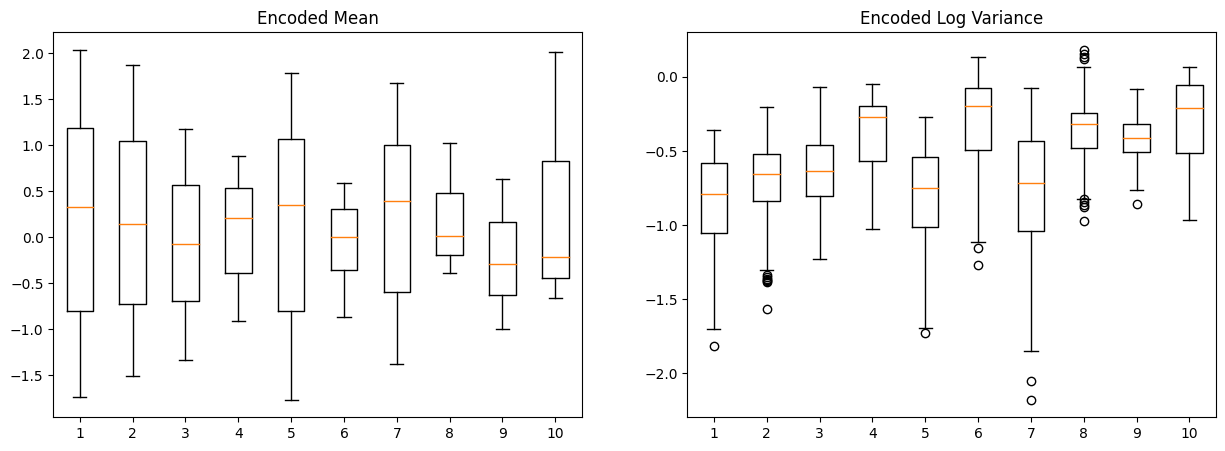

In [ ]:
encoded_mean, encoded_log_var, encoded_z = encoder(train_tensor)

# set figure size
plt.figure(figsize=(15, 5))
# boxplot of encoded_mean
plt.subplot(1, 2, 1)
plt.boxplot(encoded_mean.numpy().reshape(-1, latent_filter))
plt.title('Encoded Mean')

# boxplot of encoded_log_var
plt.subplot(1, 2, 2)
plt.boxplot(encoded_log_var.numpy().reshape(-1, latent_filter))
plt.title('Encoded Log Variance')

plt.show()

In [ ]:
start_date = '2018-01-01'
end_date = '2023-12-31 23:00:00'
dt = pd.date_range(start=start_date, end=end_date, freq='h')

gen_seasonal_inputs = fourier((dt.dayofyear[::4*24]-1)/365)[np.newaxis]
gen_seasonal_inputs.shape

(1, 548, 6)

In [ ]:
_, _, z_gen = seasonal_prior(gen_seasonal_inputs)
z_gen.shape

TensorShape([1, 548, 10])

In [ ]:
gen_mean = decoder(z_gen).numpy()
noise = np.random.normal(size=gen_mean.shape)*np.exp(0.5*vae.noise_log_var[0].numpy())
gen = gen_mean #+ noise
gen.shape

(1, 52608)

In [ ]:
gen_series = pd.Series(gen[0, :len(dt)]*18.29 + 75.08, index=dt)
gen_series

,0
2018-01-01 00:00:00,73.458076
2018-01-01 01:00:00,71.501572
2018-01-01 02:00:00,70.718704
2018-01-01 03:00:00,70.469971
2018-01-01 04:00:00,69.656693
...,...
2023-12-31 19:00:00,64.245628
2023-12-31 20:00:00,60.620747
2023-12-31 21:00:00,63.272900
2023-12-31 22:00:00,65.034927


In [ ]:
gen_series.to_csv('generated.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

In [ ]:
df = pd.read_csv('observed_time_series.csv', index_col=0, parse_dates=True).drop('Observed', axis=1)
gen = pd.read_csv('generated.csv', index_col=0, parse_dates=True).iloc[:, 0]
df['Generated'] = gen
df.columns = ['Real', 'Generated']
df

,Real,Generated
2018-01-01 00:00:00,47.868284,73.458080
2018-01-01 01:00:00,46.503868,71.501570
2018-01-01 02:00:00,44.728436,70.718704
2018-01-01 03:00:00,40.999378,70.469970
2018-01-01 04:00:00,40.888820,69.656690
...,...,...
2023-12-31 12:00:00,58.257648,64.294310
2023-12-31 13:00:00,60.614047,66.881966
2023-12-31 14:00:00,61.080524,71.950950
2023-12-31 15:00:00,61.134883,73.298670


In [ ]:
def autocorrelation(x):
    slope = np.polyfit(x[:-1], x[1:], 1)[0]
    return slope

hourly_correlation_real = autocorrelation(df.Real)
daily_correlation_real = autocorrelation(df.Real.resample('D').mean())
monthly_correlation_real = autocorrelation(df.Real.resample('MS').mean())

hourly_correlation_gen = autocorrelation(df.Generated)
daily_correlation_gen = autocorrelation(df.Generated.resample('D').mean())
monthly_correlation_gen = autocorrelation(df.Generated.resample('MS').mean())

data = {
    'Hourly': [hourly_correlation_real, hourly_correlation_gen],
    'Daily': [daily_correlation_real, daily_correlation_gen],
    'Monthly': [monthly_correlation_real, monthly_correlation_gen]
}
corr_df = pd.DataFrame(data=data, index=['Real', 'Generated']).T
corr_df

,Real,Generated
Hourly,0.989993,0.972101
Daily,0.982464,0.929744
Monthly,0.845760,0.732279


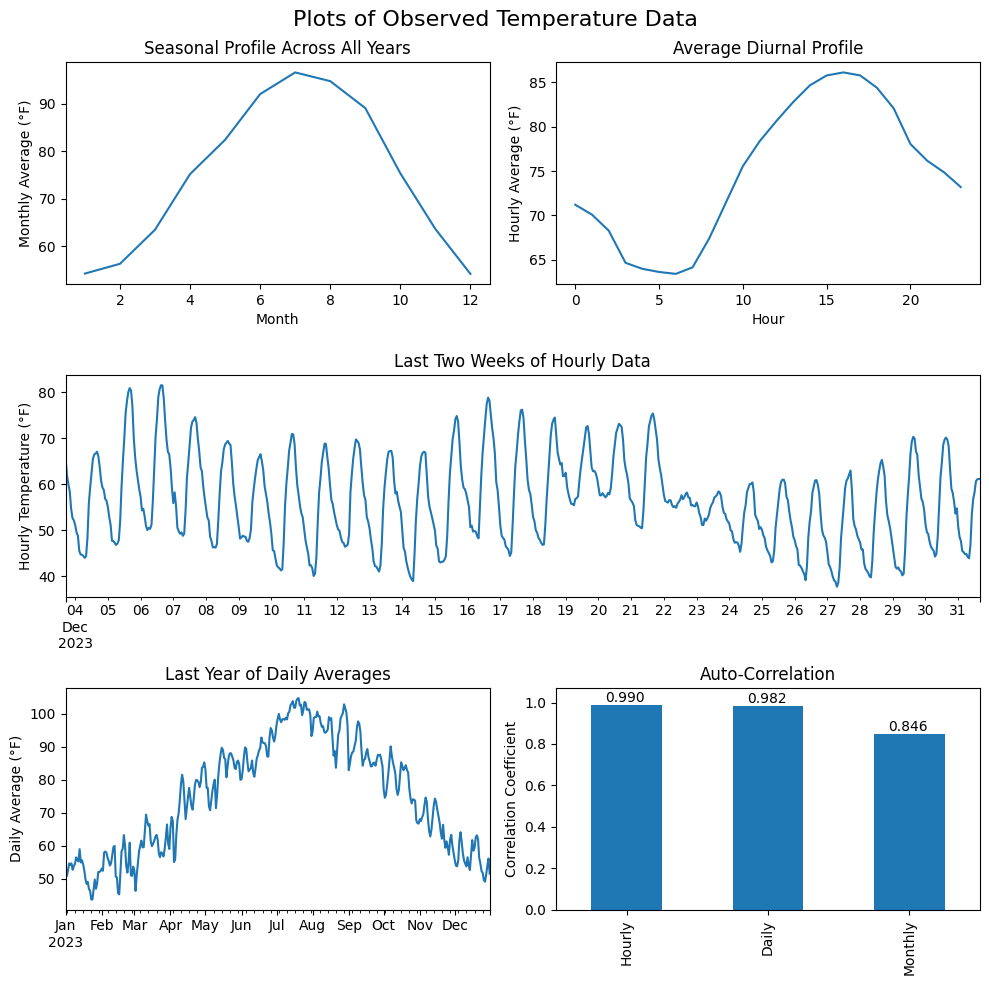

In [ ]:
# Create a GridSpec with 3 rows and 2 columns

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 2)

# Top row: 2 plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Middle row: 1 wide plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])

# Bottom row: 2 plots
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Plot seasonal profile
df.iloc[:,0].groupby(df.index.month).mean().plot(ax=ax1)
ax1.set_title('Seasonal Profile Across All Years')
ax1.set_ylabel('Monthly Average (°F)')
ax1.set_xlabel('Month')

# Plot diurnal profile
df.iloc[:,0].groupby(df.index.hour).mean().plot(ax=ax2)
ax2.set_title('Average Diurnal Profile')
ax2.set_ylabel('Hourly Average (°F)')
ax2.set_xlabel('Hour')

# Plot last two weeks of hourly data
df.iloc[-24*28:, 0].plot(ax=ax3, title='Last Two Weeks of Hourly Data')
# set y-axis label
ax3.set_ylabel('Hourly Temperature (°F)')

# Plot the last year of daily averages
df.resample('D').mean().iloc[-365:, 0].plot(ax=ax4, title='Last Year of Daily Averages')
# set y-axis label
ax4.set_ylabel('Daily Average (°F)')

# Plot correlation
# ax5.bar(corr_df.index, corr_df)
corr_df.iloc[:,0].plot(kind='bar', ax=ax5)
# set y-axis label
ax5.set_ylabel('Correlation Coefficient')
ax5.set_title('Auto-Correlation')
for i, value in enumerate(corr_df['Real']):
    ax5.text(i-0.01, value, f'{value:.3f}', ha='center', va='bottom')
# for i, value in enumerate(corr_df['Generated']):
#     ax5.text(i+0.01, value, f'{value:.3f}', ha='left', va='bottom')

plt.ylim(bottom=0, top=1.07)

# add title to entire figure
fig.suptitle('Plots of Observed Temperature Data', fontsize=16)

plt.tight_layout()
plt.show()

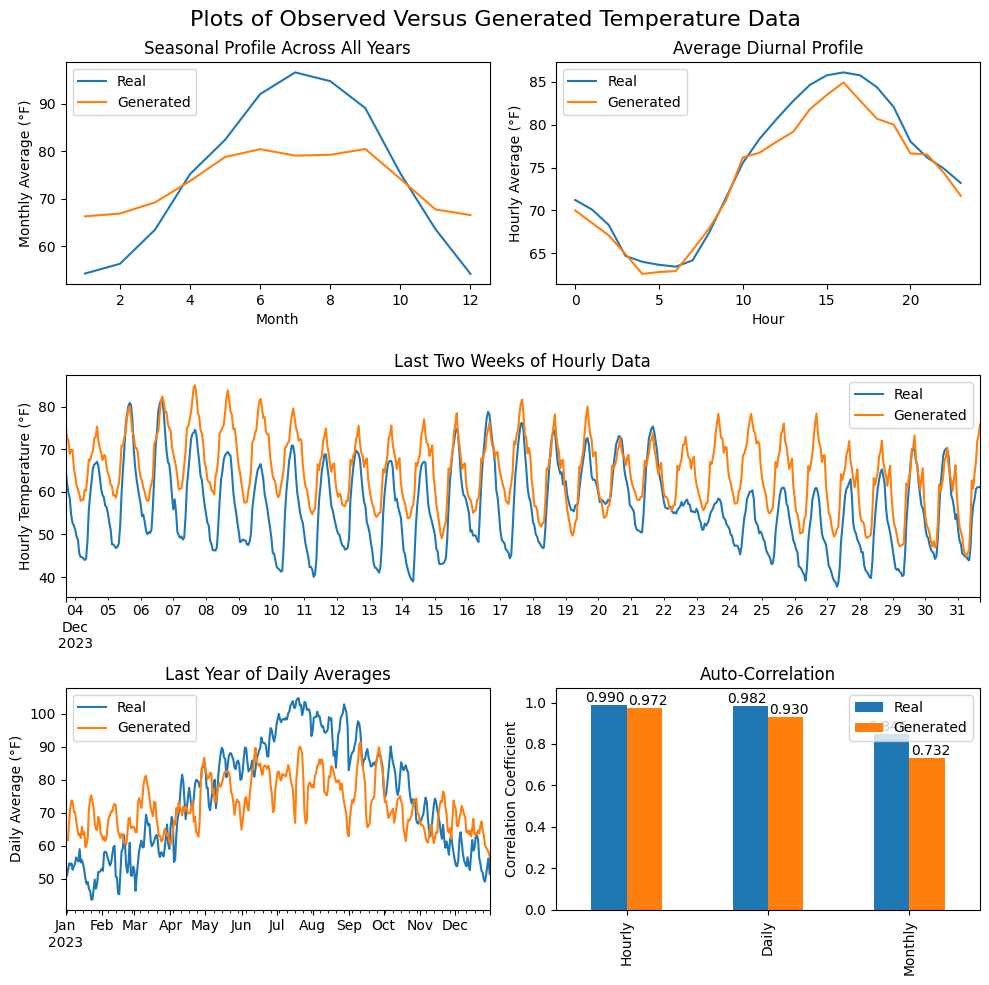

In [ ]:
# Create a GridSpec with 3 rows and 2 columns
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 2)

# Top row: 2 plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Middle row: 1 wide plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])

# Bottom row: 2 plots
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Plot seasonal profile
df.groupby(df.index.month).mean().plot(ax=ax1)
ax1.set_title('Seasonal Profile Across All Years')
ax1.set_ylabel('Monthly Average (°F)')
ax1.set_xlabel('Month')

# Plot diurnal profile
df.groupby(df.index.hour).mean().plot(ax=ax2)
ax2.set_title('Average Diurnal Profile')
ax2.set_ylabel('Hourly Average (°F)')
ax2.set_xlabel('Hour')

# Plot last two weeks of hourly data
df.iloc[-24*28:].plot(ax=ax3, title='Last Two Weeks of Hourly Data')
# set y-axis label
ax3.set_ylabel('Hourly Temperature (°F)')

# Plot the last year of daily averages
df.resample('D').mean().iloc[-365:].plot(ax=ax4, title='Last Year of Daily Averages')
# set y-axis label
ax4.set_ylabel('Daily Average (°F)')

# Plot correlation
# ax5.bar(corr_df.index, corr_df)
corr_df.plot(kind='bar', ax=ax5)
# set y-axis label
ax5.set_ylabel('Correlation Coefficient')
ax5.set_title('Auto-Correlation')
for i, value in enumerate(corr_df['Real']):
    ax5.text(i-0.01, value, f'{value:.3f}', ha='right', va='bottom')
for i, value in enumerate(corr_df['Generated']):
    ax5.text(i+0.01, value, f'{value:.3f}', ha='left', va='bottom')

plt.ylim(bottom=0, top=1.07)

fig.suptitle('Plots of Observed Versus Generated Temperature Data', fontsize=16)

plt.tight_layout()
plt.show()

### Time series generation using TimeGAN

In [1]:
!pip install tsgm -q

%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import copy
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tsgm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
data = tsgm.utils.gen_sine_dataset(10000, 24, 5)
scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_data = scaler.fit_transform(data)

model = tsgm.models.timeGAN.TimeGAN(
    seq_len=24,
    module="gru",
    hidden_dim=24,
    n_features=5,
    n_layers=3,
    batch_size=256,
    gamma=1.0,
)
# .compile() sets all optimizers to Adam by default
model.compile()

model.fit(
    data=scaled_data,
    epochs=100,
)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(256, 24, 5)]            0         
                                                                 
 Embedder (Sequential)       (256, 24, 24)             10032     
                                                                 
 Recovery (Sequential)       (256, 24, 5)              10925     
                                                                 
Total params: 20957 (81.86 KB)
Trainable params: 20957 (81.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "AdversarialSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomNoise (InputLayer)    [(256, 24, 5)]            0         
                                                      

INFO:models:Start Embedding Network Training
Autoencoder - training: 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]
INFO:models:Finished Embedding Network Training
INFO:models:Start Training with Supervised Loss Only
Adversarial Supervised - training: 100%|██████████| 100/100 [00:11<00:00,  8.49it/s]
INFO:models:Finished Training with Supervised Loss Only
INFO:models:Start Joint Training
GAN with embedding - training: 100%|██████████| 100/100 [06:17<00:00,  3.77s/it]
INFO:models:Finished Joint Training


In [3]:
new_x = model.generate(n_samples=10)
# synthetic data have shape (n_samples, sequence_lenght, n_features)
new_x.shape

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


(10, 24, 5)